<a href="https://colab.research.google.com/github/YuToyoshima/python_samples/blob/main/weathervane_serial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# ==== シミュレーション関数 ====
def simulate(init, param, numloop):
    dt = 0.1
    tau = 0.1
    v = 0.022

    m = int(round(param[0] / dt))
    n = int(round(param[1] / dt))
    w_on, w_off, w_osc, w_self, w_nmj, theta = param[2:]

    x = np.zeros(numloop+1)
    y = np.zeros(numloop+1)
    mu = np.zeros(numloop+1)
    activity = np.zeros(numloop+1)
    MND = np.zeros(numloop+1)
    MNV = np.zeros(numloop+1)

    x[0], y[0], mu[0] = init

    conc_timelapse_all = np.zeros(numloop + m + n + 1)
    conc_timelapse_all[:m+n] = nacl(x[0], y[0])

    conc_timelapse_log = np.zeros((numloop, m+n))

    for p in range(numloop):
        conc_timelapse_all[m+n+p] = nacl(x[p], y[p])
        conc_timelapse = conc_timelapse_all[p : m+n+p]
        conc_timelapse_log[p,:] = conc_timelapse
        activity[p+1] = sensory(conc_timelapse, m, n)

        I_onoff = w_on*activity[p+1] if activity[p+1] > 0 else w_off*-activity[p+1]
        I_osc = w_osc * np.sin(2*np.pi*p*dt/4.2)

        MND[p+1] = MND[p] + (-MND[p] + w_self*sigmoid(MND[p], theta) + I_onoff + I_osc)*(dt/tau)
        MNV[p+1] = MNV[p] + (-MNV[p] + w_self*sigmoid(MNV[p], theta) + I_onoff - I_osc)*(dt/tau)

        mu[p+1] = mu[p] + dt * w_nmj * (sigmoid(MND[p+1], theta) - sigmoid(MNV[p+1], theta))
        x[p+1] = x[p] + dt*v*np.cos(mu[p+1])
        y[p+1] = y[p] + dt*v*np.sin(mu[p+1])

    return x, y

# ==== 補助関数 ====
def nacl(x, y):
    return x**2 + y**2

def sensory(conc_timelapse, m, n):
    return np.mean(conc_timelapse[m:m+n]) - np.mean(conc_timelapse[:m])

def sigmoid(x, theta):
    return 1 / (1 + np.exp(-(x + theta)))


def objfun(param, numtrials=20, startdist=4.5, numloop=5000):
    # print("param.ndim:", param.ndim)
    # print("shape:", param.shape)

    if param.ndim==1:
      param = np.expand_dims(param, axis=0)
      # print("shape after expand:", param.shape)

    numIndividuals = param.shape[0] # handle multiple parameter set at once
    score = np.zeros(numIndividuals)

    for q in range(numIndividuals):
      tmpscore = np.zeros(numtrials)
      for p in range(numtrials):
          angle = np.random.rand() * 2*np.pi
          x0 = startdist * np.cos(angle)
          y0 = startdist * np.sin(angle)
          mu0 = np.random.rand() * 2*np.pi
          init = [x0, y0, mu0]
          x, y = simulate(init, param[q,:], numloop)
          tmpscore[p] = np.mean(np.sqrt(x**2 + y**2))/startdist
      score[q] = np.mean(tmpscore)
    return score

def visualizeResult(param):
    numtrials = 20
    startdist = 4.5
    numloop = 5000

    trajectories_x = []
    trajectories_y = []

    for p in range(numtrials):
        angle = np.random.rand() * 2*np.pi
        x0 = startdist * np.cos(angle)
        y0 = startdist * np.sin(angle)
        mu0 = np.random.rand() * 2*np.pi
        init = [x0, y0, mu0]
        x, y = simulate(init, param, numloop)
        trajectories_x.append(x)
        trajectories_y.append(y)

    plt.figure(figsize=(6,6))
    ct = np.linspace(-1 * np.pi, np.pi, 100)
    cx = startdist*np.cos(ct)
    cy = startdist*np.sin(ct)
    plt.plot(cx,cy,'k:')
    for x, y in zip(trajectories_x, trajectories_y):
        plt.plot(x, y)
    plt.axis('equal')
    plt.show()

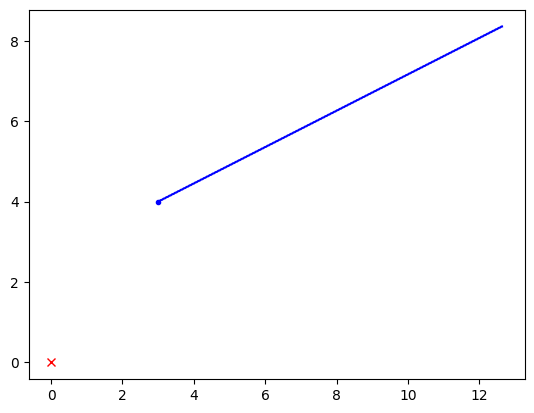

In [24]:
init0 = np.array([3,4,0]) # x=3, y=4
param0 = np.array([0.3,0.5,0.01,0.02,5,0,0.5,0])
numloop=5000
x,y = simulate(init0,param0,numloop=numloop)
plt.plot(x,y,'b-')
plt.plot(x[0],y[0],'b.')
plt.plot(0,0,'rx')

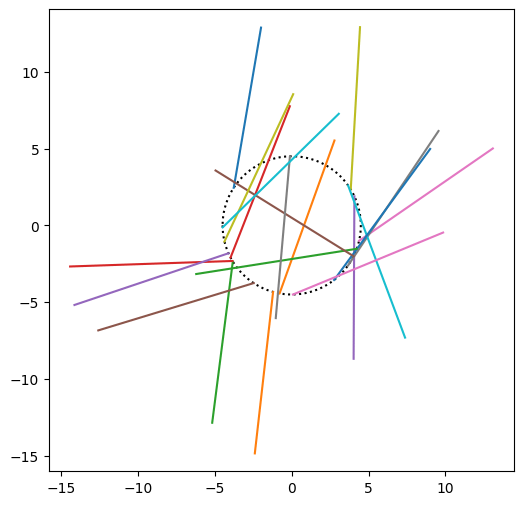

In [32]:
visualizeResult(param0)

current best score: [1.34607721]
current best score: [1.22298064]
current best score: [1.37964019]
current best score: [1.31949152]
current best score: [1.44292773]
current best score: [1.42884213]
current best score: [1.33759411]
current best score: [1.32747291]
current best score: [1.30516656]
Optimal parameters: [  3.30459494   1.95330811 -13.71995598  14.96581464   1.23737615
  11.45361832   1.54605816   7.47346658]
Objective value: 1.182742529264715


/tmp/ipython-input-805834004.py:15: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(objfun, param0, method='Nelder-Mead', callback=my_callback, options={'maxiter':10, 'disp':True}) # 範囲制約なし


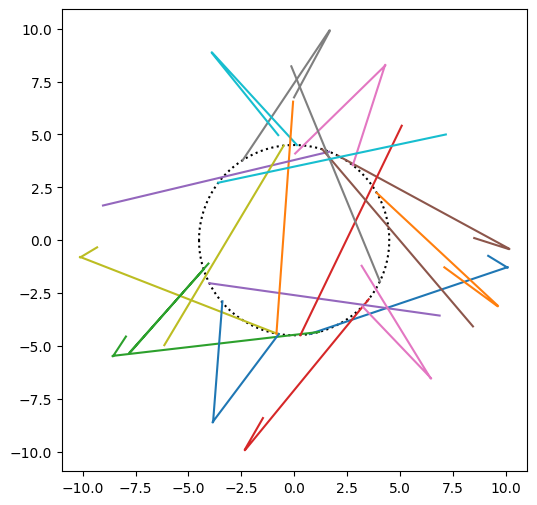

In [42]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

def my_callback(xk):
    print("current best score:", objfun(xk))

# ===== パラメータ境界 =====
lowerbound = [0.1, 0.1, -15, -15,  0,  0, 1, -15]
upperbound = [4.2, 4.2,  15,  15, 15, 15, 3,  15]

# ===== 初期パラメータ =====
param0 = np.random.rand(len(upperbound)) * (np.array(upperbound) - np.array(lowerbound)) + np.array(lowerbound)

# ===== 最適化 =====
result = minimize(objfun, param0, method='Nelder-Mead', callback=my_callback, options={'maxiter':10, 'disp':True}) # 範囲制約なし
# result = differential_evolution(objfun, bounds=list(zip(lowerbound, upperbound)), callback=my_callback, maxiter=10, popsize=10, disp=True) # 範囲制約付き
param_opt = result.x
fval = result.fun

print("Optimal parameters:", param_opt)
print("Objective value:", fval)

# ===== 結果の可視化 =====
visualizeResult(param_opt)

In [8]:
!pip install pymoo

In [11]:
# ---------------------------
# pymoo用ラッパーとGA設定
# ---------------------------
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.callback import Callback
import time


# 目的関数ラッパー
def objfun_for_pymoo(x):
    """
    x: 2D array shape (numIndividuals, 8)
    returns: 1D array shape (numIndividuals,)
    """
    scores = objfun(x, numtrials=20, startdist=4.5, numloop=5000)
    # pymooは最小化問題なので、スコアが高い方が良い場合は反転
    return scores

# pymoo Problem 定義
class MyProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=8,            # パラメータ数
            n_obj=1,            # 1目的
            n_constr=0,         # 制約なし
            xl = np.array([0.1, 0.1, -15, -15,  0,  0, 1, -15]),
            xu = np.array([4.2, 4.2,  15,  15, 15, 15, 3,  15])
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # X: (pop_size, n_var)
        # out["F"]: (pop_size, n_obj)
        scores = objfun_for_pymoo(X)
        # GAは最小化問題のため、スコアをそのまま返す
        out["F"] = scores.reshape(-1, 1)


class MyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.best_per_gen = []
        self.mean_per_gen = []
        self.worst_per_gen = []
        self.elapsed_time = []
        self.start_time = None

    def notify(self, algorithm):
        if self.start_time is None:
            self.start_time = time.time()  # 最初の世代で開始時刻を記録

        F = algorithm.pop.get("F").flatten()  # 目的関数値 (pop_size,)
        best = np.min(F)
        mean = np.mean(F)
        worst = np.max(F)
        elapsed = time.time() - self.start_time

        # データを蓄積
        self.best_per_gen.append(best)
        self.mean_per_gen.append(mean)
        self.worst_per_gen.append(worst)
        self.elapsed_time.append(elapsed)

        # ログ表示
        print(f"Gen {algorithm.n_gen:3d} | Best: {best:.6f} | Mean: {mean:.6f} | Worst: {worst:.6f} | Elapsed: {elapsed:.1f} s")

In [21]:
# ---------------------------
# GA 実行
# ---------------------------
problem = MyProblem()

algorithm = NSGA2(
    pop_size=20,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 10),  # 世代数
    verbose=False,
    callback=MyCallback()
)

# ---------------------------
# 結果表示
# ---------------------------
print("Best parameters found:")
print(res.X)
print("Best score:")
print(res.F)

# T4 GPU: 45 sec (parallel version)
# CPU: 36 sec (parallel version)
# CPU: 589 sec (serial version)

Gen   1 | Best: 0.459287 | Mean: 1.244776 | Worst: 1.937787 | Elapsed: 0.0 s
Gen   2 | Best: 0.397352 | Mean: 0.861125 | Worst: 1.184829 | Elapsed: 67.9 s
Gen   3 | Best: 0.397352 | Mean: 0.701713 | Worst: 0.908755 | Elapsed: 130.1 s
Gen   4 | Best: 0.397352 | Mean: 0.604813 | Worst: 0.738591 | Elapsed: 196.6 s
Gen   5 | Best: 0.397029 | Mean: 0.502583 | Worst: 0.572406 | Elapsed: 260.3 s
Gen   6 | Best: 0.325190 | Mean: 0.458267 | Worst: 0.525189 | Elapsed: 326.0 s
Gen   7 | Best: 0.291925 | Mean: 0.414119 | Worst: 0.474609 | Elapsed: 390.7 s
Gen   8 | Best: 0.291925 | Mean: 0.373446 | Worst: 0.425623 | Elapsed: 452.7 s
Gen   9 | Best: 0.285313 | Mean: 0.334895 | Worst: 0.389074 | Elapsed: 522.2 s
Gen  10 | Best: 0.285313 | Mean: 0.301946 | Worst: 0.325759 | Elapsed: 588.8 s
Best parameters found:
[  0.79582652   0.15277296  14.5000896  -14.32886115   2.87968603
   4.0701832    2.50061867  -4.66412391]
Best score:
[0.28531341]


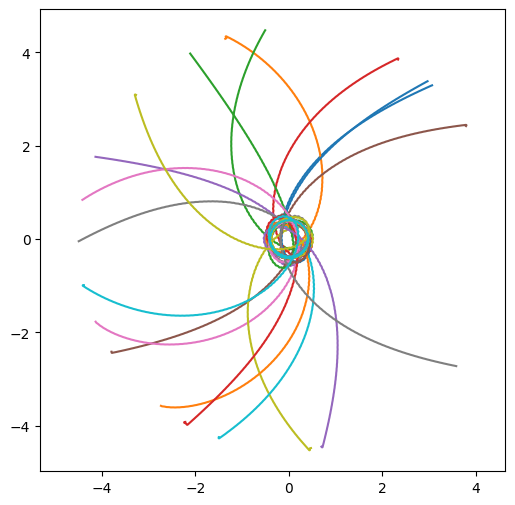

In [22]:
# ===== 結果の可視化 =====
visualizeResult(res.X)